In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import numpy as np
import pickle
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import scipy.stats as stats
import lightgbm as lgb
#from lightgbm import LGBMClassifier
import warnings
from matplotlib.ticker import FuncFormatter
from sklearn.calibration import CalibrationDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import wandb

/Users/yassine/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_standard = pd.read_csv('dataframe/combined_shots_data.csv')
df_enriched= pd.read_csv('dataframe/train_data_enriched.csv')

In [3]:
df_enriched

,game_id,game_seconds,game_period,x_coord,y_coord,shot_distance,shot_angle,shot_type,empty_net,last_event_type,...,distance_from_last_event,friendly_skaters,opposing_skaters,attacking_team_id,attacking_team_name,home_team,is_goal,rebound,shot_angle_change,speed
0,2016020001,63,1,-43.0,23.0,51.429563,26.565051,NaN,1,takeaway,...,40.853396,5,5,10,Maple Leafs,Senators,0,False,0.000000,2.042670
1,2016020001,70,1,-61.0,11.0,30.083218,21.447736,NaN,1,blocked-shot,...,21.633308,5,5,10,Maple Leafs,Senators,0,False,0.000000,3.090473
2,2016020001,71,1,-77.0,5.0,13.000000,22.619865,wrist,0,blocked-shot,...,17.088007,5,5,10,Maple Leafs,Senators,0,False,0.000000,17.088007
3,2016020001,125,1,56.0,-2.0,33.060551,3.468229,NaN,1,shot-on-goal,...,133.184083,5,5,9,Senators,Senators,0,True,-19.151636,2.466372
4,2016020001,134,1,52.0,9.0,38.078866,-13.671307,wrist,0,blocked-shot,...,11.704700,5,5,9,Senators,Senators,0,False,0.000000,1.300522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607061,2019030416,3560,3,79.0,-2.0,10.198039,11.309932,NaN,1,blocked-shot,...,10.770330,6,5,25,Stars,Stars,0,False,0.000000,3.590110
607062,2019030416,3567,3,31.0,10.0,58.855756,-9.782407,wrist,0,faceoff,...,49.678969,6,5,25,Stars,Stars,0,False,0.000000,9.935794
607063,2019030416,3575,3,84.0,7.0,8.602325,-54.462322,wrist,0,shot-on-goal,...,53.084838,6,5,25,Stars,Stars,0,True,-44.679915,6.635605
607064,2019030416,3585,3,77.0,0.0,12.000000,-0.000000,wrist,0,missed-shot,...,9.899495,6,5,25,Stars,Stars,0,False,0.000000,0.989949


In [4]:
df_enriched.columns

Index(['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord',
       'shot_distance', 'shot_angle', 'shot_type', 'empty_net',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'distance_from_last_event', 'friendly_skaters',
       'opposing_skaters', 'attacking_team_id', 'attacking_team_name',
       'home_team', 'is_goal', 'rebound', 'shot_angle_change', 'speed'],
      dtype='object')

# distinction des caracteristiques

In [5]:
data_categ = df_enriched.select_dtypes(include=['object'])
data_numer = df_enriched.select_dtypes(include=['float64', 'int64'])
data_bool = df_enriched.select_dtypes(include=['bool'])

In [6]:
data_categ = data_categ.drop(['attacking_team_name','home_team'], axis=1)

In [7]:
data_numer = data_numer.drop(['game_id','game_seconds','game_period','time_since_last_event','attacking_team_id'], axis=1)

In [8]:
# Label encoding
le = LabelEncoder()
data_categ = data_categ.apply(le.fit_transform)
data_categ

# Concatenate all features
df_final= pd.concat([data_categ, data_numer, data_bool], axis=1)
df_final

,shot_type,last_event_type,x_coord,y_coord,shot_distance,shot_angle,empty_net,last_event_x,last_event_y,distance_from_last_event,friendly_skaters,opposing_skaters,is_goal,shot_angle_change,speed,rebound
0,7,13,-43.0,23.0,51.429563,26.565051,1,-81.0,38.0,40.853396,5,5,0,0.000000,2.042670,False
1,7,0,-61.0,11.0,30.083218,21.447736,1,-43.0,23.0,21.633308,5,5,0,0.000000,3.090473,False
2,6,0,-77.0,5.0,13.000000,22.619865,0,-61.0,11.0,17.088007,5,5,0,0.000000,17.088007,False
3,7,11,56.0,-2.0,33.060551,3.468229,1,-77.0,5.0,133.184083,5,5,0,-19.151636,2.466372,True
4,6,0,52.0,9.0,38.078866,-13.671307,0,56.0,-2.0,11.704700,5,5,0,0.000000,1.300522,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607061,7,0,79.0,-2.0,10.198039,11.309932,1,75.0,-12.0,10.770330,6,5,0,0.000000,3.590110,False
607062,6,2,31.0,10.0,58.855756,-9.782407,0,69.0,-22.0,49.678969,6,5,0,0.000000,9.935794,False
607063,6,11,84.0,7.0,8.602325,-54.462322,0,31.0,10.0,53.084838,6,5,0,-44.679915,6.635605,True
607064,6,7,77.0,0.0,12.000000,-0.000000,0,84.0,7.0,9.899495,6,5,0,0.000000,0.989949,False


In [9]:
df_final.columns

Index(['shot_type', 'last_event_type', 'x_coord', 'y_coord', 'shot_distance',
       'shot_angle', 'empty_net', 'last_event_x', 'last_event_y',
       'distance_from_last_event', 'friendly_skaters', 'opposing_skaters',
       'is_goal', 'shot_angle_change', 'speed', 'rebound'],
      dtype='object')

In [10]:
X = df_final.drop(['is_goal'], axis =1)
y = df_final['is_goal']

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=0)

clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=50,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, num_boost_round=100)

clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

/Users/yassine/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 21865, number of negative: 403081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 424946, number of used features: 15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051454 -> initscore=-2.914250
[LightGBM] [Info] Start training from score -2.914250


LGBMClassifier(metric='auc', n_jobs=-1, num_boost_round=100, num_leaves=50,
               objective='binary')

/Users/yassine/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 21865, number of negative: 403081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 424946, number of used features: 15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051454 -> initscore=-2.914250
[LightGBM] [Info] Start training from score -2.914250


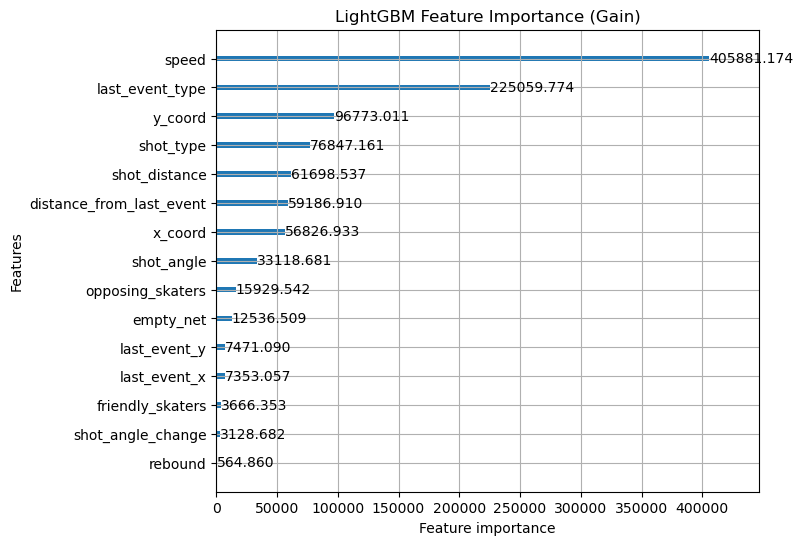

In [12]:
lgb.plot_importance(clf, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
gain_selection= clf.feature_importances_

gain_selection_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance_Gain': gain_selection,
    })

# Sort df by importance in descending order
features_df = gain_selection_df.sort_values(by='Importance_Gain', ascending=False)
features = features_df['Features'].head(20).tolist()
data_selected = df_final[features]
X_selected = data_selected
y_selected = df_final['is_goal']

X_train, X_valid, y_train, y_valid = train_test_split(X_selected, y_selected, test_size=0.30, random_state=0)

clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.1, n_estimators=100, n_jobs=-1, num_leaves=40,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, num_boost_round=100)

clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
y_prediction=clf.predict(X_valid)
proba = clf.predict_proba(X_valid)[:, 1]

In [13]:
#y_prediction = clf.predict(X_valid)

In [14]:
accuracy=accuracy_score(y_prediction, y_valid)
print('LightGBM accuracy: {0:0.4f}'.format(accuracy_score(y_valid, y_prediction)))

from sklearn.metrics import classification_report
print('Classification report\n\n', classification_report(y_valid, y_prediction))

p = clf.predict_proba(X_valid) # predict probabilities
proba = p[:, 1] # proba for the positive outcome only
# AUC
aucvalue= roc_auc_score(y_valid, proba)
print('AUC: %.3f' % aucvalue)

LightGBM accuracy: 0.9498
Classification report

               precision    recall  f1-score   support

           0       0.95      1.00      0.97    172810
           1       0.64      0.04      0.07      9310

    accuracy                           0.95    182120
   macro avg       0.79      0.52      0.52    182120
weighted avg       0.93      0.95      0.93    182120

AUC: 0.839


In [15]:
metrics = {
        "accuracy": accuracy,
        "roc_auc": aucvalue,
        "precision": precision_score(y_valid, y_prediction),
        "recall": recall_score(y_valid, y_prediction),
        "f1-score": f1_score(y_valid, y_prediction),
    }

In [16]:
metrics

{'accuracy': 0.9497529101691192,
 'roc_auc': 0.8387980541017492,
 'precision': 0.6392294220665499,
 'recall': 0.03920515574650913,
 'f1-score': 0.0738791620281348}

In [17]:
wandb.init(project="IFT6758.2024-A", id="lightgbm_Q6", resume="allow")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yassine-faik (hicham-mazouzi-university-of-montreal). Use `wandb login --relogin` to force relogin


# Plots

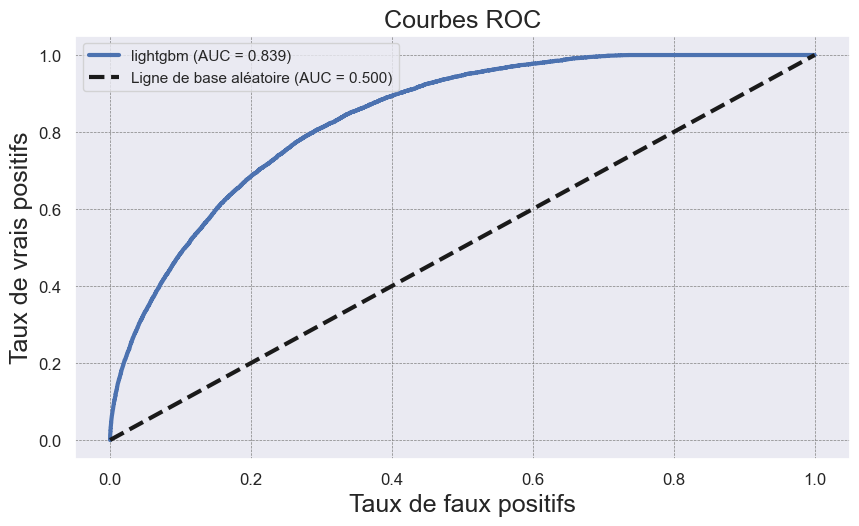

In [18]:
fpr, tpr, thresholds = roc_curve(y_valid, proba)
auc_score = auc(fpr, tpr)

def courbe_roc_auc(fpr,tpr,auc_score):
    sns.set()

    fig, ax = plt.subplots(figsize=(10, 5.5))

    plt.plot(fpr, tpr, label='lightgbm (AUC = {:.3f})'.format(auc_score), lw=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Ligne de base aléatoire (AUC = 0.500)', lw=3)

    ax.set_ylabel('Taux de vrais positifs', fontsize=18)
    ax.set_xlabel('Taux de faux positifs', fontsize=18)
    ax.set_title("Courbes ROC", fontsize=18)
    ax.tick_params(labelsize=12)

    plt.legend(loc='best')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    #plt.show()
    plot_filename = "roc_curve_lightgbm.png"
    plt.savefig(plot_filename)
    #return fig
    return fig, plot_filename

roc = courbe_roc_auc(fpr,tpr,auc_score)

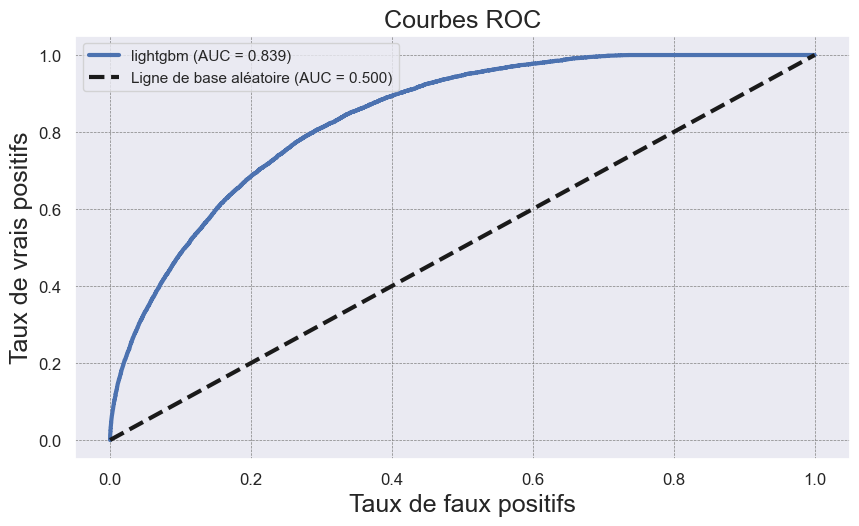

In [19]:
# Initialize Wandb
#wandb.init(project="decision_tree_classification", name="roc_curve_decision_tree")
wandb.init(project="IFT6758.2024-A", id="lightgbm_Q6", resume="allow")
# Generate and log the ROC plot
roc_fig, roc_plot_filename = courbe_roc_auc(fpr,tpr,auc_score)

# Log the plot to Wandb
wandb.log({"ROC Curve": wandb.Image(roc_plot_filename)})

# Finish Wandb logging
wandb.finish()

In [20]:
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

def plot_taux_reussite_but(df_prob=None, n_bins=20, quant=5, list_labels=None):
    
    palette_couleurs = ['orange', 'black', 'blue', 'red']

    df_prob_1 = df_prob.copy()
    cols = df_prob.columns[1:-1]

    df_percentil, compteur_but, compteur_tir, goal_rate, pencentil = [], [], [], [], []

    for col in cols:
        df_prob_1['percentile'] = df_prob_1[col].rank(pct=True)
        quantile_list = np.linspace(0, 1, n_bins * quant + 1).round(4).tolist()
        q = df_prob_1.quantile(quantile_list)
        for i in np.arange(quant, (quant * n_bins) + 1, quant):
            df_percentil = df_prob_1[((df_prob_1[col] >= q[col][(i - quant) / 100]) & (df_prob_1[col] < q[col][i / 100]))]
            compteur_but.append(df_percentil['is_goal'].sum())
            compteur_tir.append(df_percentil['compteur_tir'].sum())
            goal_rate.append(df_percentil['is_goal'].sum() / df_percentil['compteur_tir'].sum())
            pencentil.append(i)

    # plots df
    df_percentil_prop = pd.DataFrame(list(zip(compteur_but, compteur_tir, goal_rate, pencentil)),
                                 columns=['compteur_but', "sum_compteur_tir", 'goal_rate', 'pencentil'])

    # Plots
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    for i in range(len(list_labels)):
        ax = sns.lineplot(x=df_percentil_prop.pencentil[i * n_bins:n_bins * (i + 1) - 1],
                          y=df_percentil_prop.goal_rate[i * n_bins:n_bins * (i + 1) - 1],
                          label=f'{list_labels[i]}', color=palette_couleurs[i], legend=False, linewidth=3)

    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=1)
    ax.legend(fontsize=12)
    ax.set_ylabel('But / (Tir + But)')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    ax.set_title(f"Taux de réussite des buts vs. Percentile du modèle de probabilité de tir")
    ax.set_xticks(np.arange(0, 101, 10))

    # y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter)) # y-axis comme pourcentage
    plot_filename = "goal_success_rate.png"
    plt.savefig(plot_filename)
    
    plt.grid(color='white', linestyle='--', linewidth=0.8)
    wandb.init(project="IFT6758.2024-A", id="lightgbm_Q6", resume="allow")
    wandb.log({"Goal Success Rate": wandb.Image("goal_success_rate.png")})
    plt.show()

In [21]:
df_prob = pd.DataFrame({'is_goal':y_valid, 'proba':proba})
df_prob['compteur_tir'] = 1

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


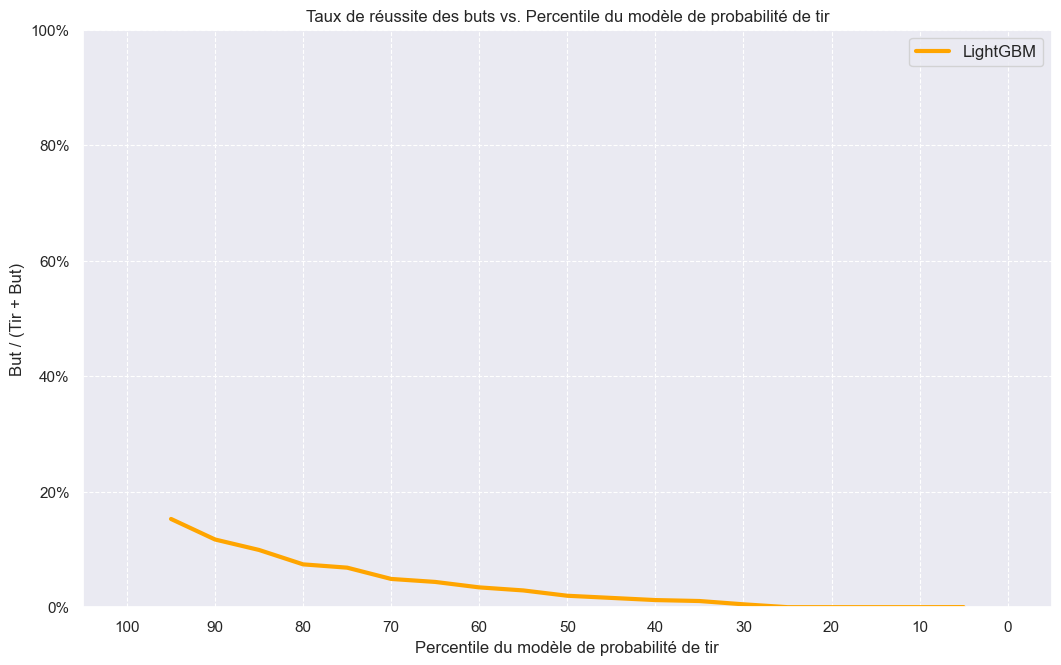

In [22]:
plot_taux_reussite_but(df_prob=df_prob, list_labels=['LightGBM'], n_bins=20, quant=5)

In [23]:
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

def plot_taux_reussite_cumulatif(df_prob=None, n_bins=20, quant=5, list_labels=None):
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    palette_couleurs = ['orange', 'black', 'blue', 'red', 'purple']

    compteur_but, pencentil, cum_goal_rate = [], [], []

    df_prob = df_prob.copy()

    cols = df_prob.columns[1:-1]

    for col in cols:
        temp, j = 0, 100
        df_prob['percentile'] = df_prob[col].rank(pct=True)
        quantile_list = np.linspace(0, 1, n_bins * quant + 1).round(4).tolist()
        q = df_prob.quantile(quantile_list)
        total = df_prob['is_goal'].sum()

        for j in np.arange((quant * n_bins), 0, -quant):
            df_perc = df_prob[((df_prob[col] > q[col][(j - quant) / 100]) & (df_prob[col] <= q[col][j / 100]))]
            compteur_but.append(df_perc.is_goal.sum())
            temp += df_perc.is_goal.sum()
            cum_goal_rate.append(temp / total)
            pencentil.append(j)

    for i in range(len(list_labels)):
        ax = sns.lineplot(x=pencentil[i * n_bins:n_bins * (i + 1) - 1], y=cum_goal_rate[i * n_bins:n_bins * (i + 1) - 1],
                          label=f'{list_labels[i]}', color=palette_couleurs[i], legend=False, linewidth=3)

    sns.set()
    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=max(cum_goal_rate) + 0.05)
    ax.set_ylabel('Proportion de buts cumulés')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    ax.set_title(f"Taux de réussite cumulatif des buts vs. Percentile du modèle de probabilité de tir")
    ax.legend(fontsize=12)
    plt.grid(color='white', linestyle='--', linewidth=0.5)

    ax.set_xticks(np.arange(0, 101, 10))
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    plot_filename = "cumulative_goals.png"
    plt.savefig(plot_filename)
    
    plt.grid(color='white', linestyle='--', linewidth=0.8)
    wandb.init(project="IFT6758.2024-A", id="lightgbm_Q6", resume="allow")
    wandb.log({"Cumulative Goal": wandb.Image("cumulative_goals.png")})
    plt.show()

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


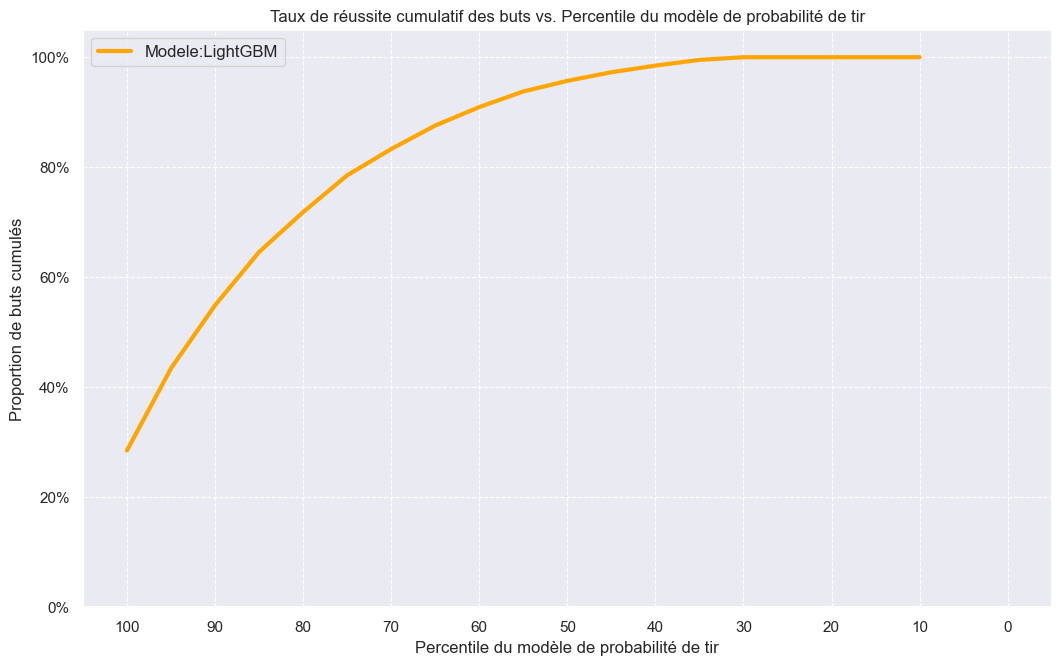

In [24]:
plot_taux_reussite_cumulatif(df_prob=df_prob, n_bins=20, quant=5, list_labels=['Modele:LightGBM'])

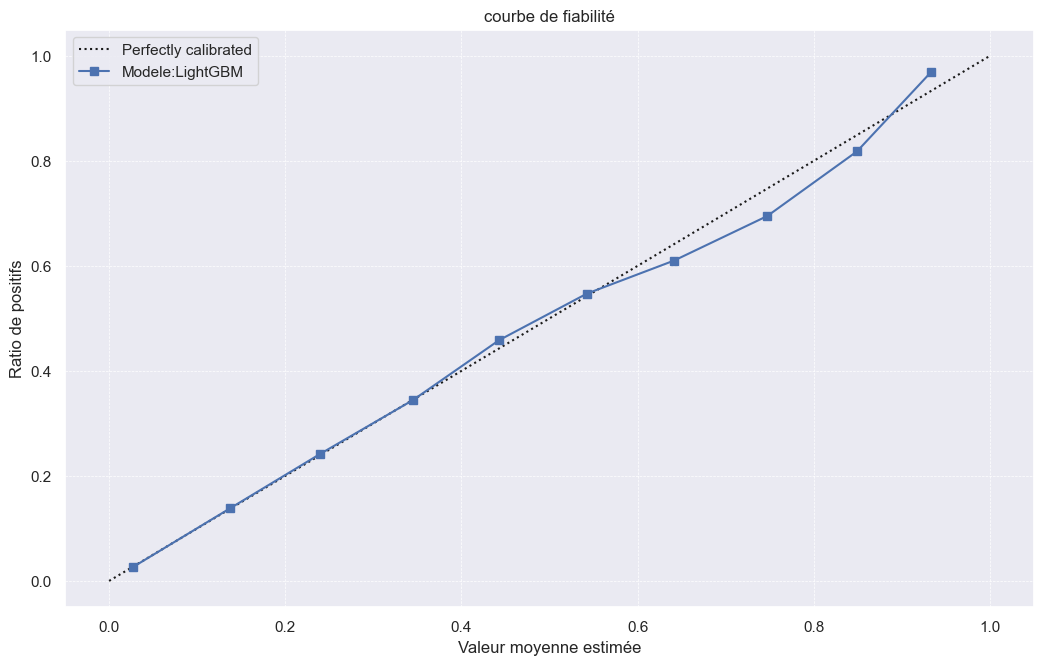

In [25]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(figsize=(12.5, 7.5))


y_pred_vec = [proba]
y_val = [y_valid]
model_names = ['Modele:LightGBM']

for idx, y_pred in enumerate(y_pred_vec):
    y_val_flat = np.ravel(y_val[0][:len(proba)]) 
    y_pred_flat = np.ravel(proba)
    disp = CalibrationDisplay.from_predictions(y_val_flat, y_pred_flat, n_bins=10, label=model_names[idx], ax=ax)

sns.set()
ax.set_ylabel("Ratio de positifs")
ax.set_ylim([-0.05, 1.05])
ax.set_title('courbe de fiabilité')
ax.set_xlabel("Valeur moyenne estimée")
ax.set_ylabel("Ratio de positifs")
plt.legend(loc='best')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()

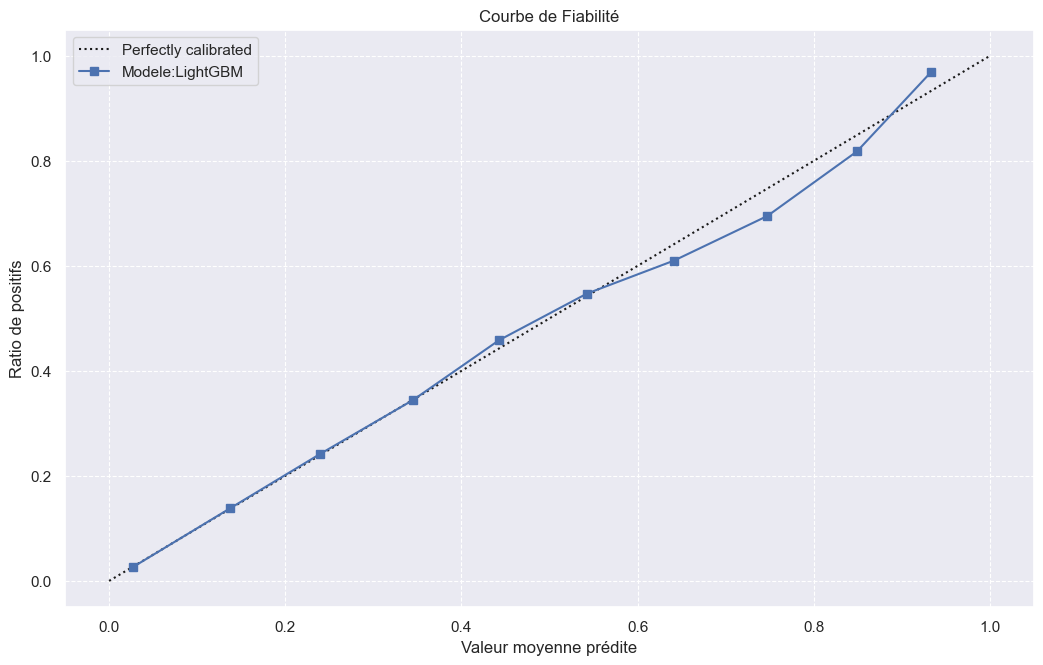

In [26]:
def plot_calibration(y_pred_vec, y_val):
    fig, ax = plt.subplots(figsize=(12.5, 7.5))

    for idx, y_pred in enumerate(y_pred_vec):
        y_val_flat = np.ravel(y_val[idx][:len(y_pred)])  # Flatten and align lengths
        y_pred_flat = np.ravel(y_pred)
        CalibrationDisplay.from_predictions(y_val_flat, y_pred_flat, n_bins=10, label=model_names[idx], ax=ax)

    sns.set()
    ax.set_ylabel("Ratio de positifs")
    ax.set_ylim([-0.05, 1.05])
    ax.set_title('Courbe de Fiabilité')
    ax.set_xlabel("Valeur moyenne prédite")
    plt.legend(loc='best')
    plt.grid(color='white', linestyle='--', linewidth=0.8)

    # Save and log to Wandb
    wandb.init(project="IFT6758.2024-A", id="lightgbm_Q6", resume="allow")
    plt.savefig("calibration_plot.png")  # Save locally
    wandb.log({"Calibration Plot": wandb.Image("calibration_plot.png")})  # Log to Wandb
    plt.show()

# Call the function
plot_calibration(y_pred_vec, y_val)

In [ ]:
lgb.plot_importance(clf, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [ ]:
gain_selection= clf.feature_importances_

gain_selection_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance_Gain': gain_selection,
})

# Sort df by importance in descending order
features_df = gain_selection_df.sort_values(by='Importance_Gain', ascending=False)

In [ ]:
features = features_df['Features'].head(20).tolist()

In [ ]:
features

In [ ]:
data_selected = df_final[features]

In [ ]:
data_selected

In [ ]:
X_selected = data_selected
y_selected = df_final['is_goal']

X_train, X_valid, y_train, y_valid = train_test_split(X_selected, y_selected, test_size=0.30, random_state=0)

clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.1, n_estimators=100, n_jobs=-1, num_leaves=40,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, num_boost_round=100)

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

In [ ]:
y_predictions=clf.predict(X_valid)

In [ ]:
accuracy=accuracy_score(y_predictions, y_valid)
print('LightGBM accuracy: {0:0.4f}'.format(accuracy_score(y_valid, y_predictions)))

from sklearn.metrics import classification_report
print('Classification report\n\n', classification_report(y_valid, y_predictions))

p = clf.predict_proba(X_valid) # predict probabilities
proba = p[:, 1] # proba for the positive outcome only
# AUC
auc = roc_auc_score(y_valid, proba)
print('AUC: %.3f' % auc)

In [ ]:
metrics = {
        "accuracy": accuracy,
        "roc_auc": auc,
        "precision": precision_score(y_valid, y_prediction),
        "recall": recall_score(y_valid, y_prediction),
        "f1-score": f1_score(y_valid, y_prediction),
    }

metrics

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, proba)

sns.set()

fig, ax = plt.subplots(figsize=(10, 5.5))

plt.plot(fpr, tpr, label='LightGBM (AUC = {:.3f})'.format(auc), lw=3)
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline (AUC = 0.500)', lw=3)

ax.set_ylabel('Taux vrais positifs', fontsize=20)
ax.set_xlabel('Taux faux positifs', fontsize=20)
ax.set_title("ROC", fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(loc='best')
plt.grid(color='gray', linestyle='--', linewidth=0.8)
plt.show()

In [ ]:
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

def plot_taux_reussite_but(df_prob=None, n_bins=20, quant=5, list_labels=None):
    
    palette_couleurs = ['orange', 'black', 'blue', 'red']

    df_prob_1 = df_prob.copy()
    cols = df_prob.columns[1:-1]

    df_percentil, compteur_but, compteur_tir, goal_rate, pencentil = [], [], [], [], []

    for col in cols:
        df_prob_1['percentile'] = df_prob_1[col].rank(pct=True)
        quantile_list = np.linspace(0, 1, n_bins * quant + 1).round(4).tolist()
        q = df_prob_1.quantile(quantile_list)
        for i in np.arange(quant, (quant * n_bins) + 1, quant):
            df_percentil = df_prob_1[((df_prob_1[col] >= q[col][(i - quant) / 100]) & (df_prob_1[col] < q[col][i / 100]))]
            compteur_but.append(df_percentil['is_goal'].sum())
            compteur_tir.append(df_percentil['compteur_tir'].sum())
            goal_rate.append(df_percentil['is_goal'].sum() / df_percentil['compteur_tir'].sum())
            pencentil.append(i)

    # plots df
    df_percentil_prop = pd.DataFrame(list(zip(compteur_but, compteur_tir, goal_rate, pencentil)),
                                 columns=['compteur_but', "sum_compteur_tir", 'goal_rate', 'pencentil'])

    # Plots
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    for i in range(len(list_labels)):
        ax = sns.lineplot(x=df_percentil_prop.pencentil[i * n_bins:n_bins * (i + 1) - 1],
                          y=df_percentil_prop.goal_rate[i * n_bins:n_bins * (i + 1) - 1],
                          label=f'{list_labels[i]}', color=palette_couleurs[i], legend=False, linewidth=3)

    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=1)
    ax.legend(fontsize=12)
    ax.set_ylabel('But / (Tir + But)')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    ax.set_title(f"Taux de réussite des buts vs. Percentile du modèle de probabilité de tir")
    ax.set_xticks(np.arange(0, 101, 10))

    # y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    
    plt.grid(color='white', linestyle='--', linewidth=0.5)
    plt.show()

plot_taux_reussite_cumulatif(df_prob=df_prob, n_bins=20, quant=5, list_labels=['Modele:LightGBM'])

In [ ]:
fig, ax = plt.subplots(figsize=(12.5, 7.5))


y_pred_vec = [proba]
y_val = [y_valid]
model_names = ['Modele:LightGBM']

for idx, y_pred in enumerate(y_pred_vec):
    y_val_flat = np.ravel(y_val[0][:len(proba)]) 
    y_pred_flat = np.ravel(proba)
    disp = CalibrationDisplay.from_predictions(y_val_flat, y_pred_flat, n_bins=10, label=model_names[idx], ax=ax)

sns.set()
ax.set_ylabel("Ratio de positifs")
ax.set_ylim([-0.05, 1.05])
ax.set_title('courbe de fiabilité')
ax.set_xlabel("Valeur moyenne estimée")
ax.set_ylabel("Ratio de positifs")
plt.legend(loc='best')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()